In [1]:
import pandas 
import numpy as np    
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
# could consider umap instead? 
# http://practicalcheminformatics.blogspot.com/2024/11/some-thoughts-on-splitting-chemical.html
# https://greglandrum.github.io/rdkit-blog/posts/2023-03-02-clustering-conformers.html
from rdkit.ML.Cluster import  Butina
from rdkit import DataStructs

def valid_pka_or_None(val):
    s_val = str(val)
    try:
        return float(val)
    except ValueError as e:
        if "~" in s_val or "<" in s_val or ">" in s_val or "temp" in s_val or "not_stated" in s_val:
            return None
        else:
            to_range = [" to ","-"]
            for r in to_range:
                if r in s_val:
                    return np.mean([float(f) for f in s_val.split(r)])
            return None            


def distances(fp_list):
    # see https://github.com/PatWalters/workshop/blob/master/clustering/taylor_butina.ipynb
    dists = []
    nfps = len(fp_list)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        dists.extend([1-x for x in sims])
    return dists
    
def cluster_ids(fp_list,cutoff=0.35):
    nfps = len(fp_list)
    mol_clusters = Butina.ClusterData(distances(fp_list),nfps,cutoff,isDistData=True)
    cluster_id_list = [0]*nfps
    for idx,cluster in enumerate(mol_clusters,1):
        for member in cluster:
            cluster_id_list[member] = idx
    return cluster_id_list

def fit(mols,pka,radius = 2,fingerprint_size=512,n_jobs=None,params=None,
        generator=rdFingerprintGenerator.GetMorganGenerator):
    if params is None:
        params = { 'max_depth': [1,2,3, 4],'n_estimators': [2,10,50,100,200]}
    if generator == rdFingerprintGenerator.GetRDKitFPGenerator:
        fp_generator = generator(maxPath=2*radius,fpSize=fingerprint_size)
    elif generator == rdFingerprintGenerator.GetAtomPairGenerator:
        fp_generator = generator(maxDistance=2*radius,fpSize=fingerprint_size)
    elif generator == rdFingerprintGenerator.GetTopologicalTorsionGenerator:
        fp_generator = generator(torsionAtomCount=radius,fpSize=fingerprint_size)
    else:
        fp_generator = generator(radius=radius,fpSize=fingerprint_size)
    X = np.array([list(e) for e in mols.transform(fp_generator.GetFingerprint)],dtype=bool)
    X_train, X_test, y_train, y_test = train_test_split(X, pka, random_state=42)
    # Use "hist" for constructing the trees, with early stopping enabled.
    model = xgb.XGBRegressor()
    grid = GridSearchCV(estimator=model, 
                        param_grid=params,
                        scoring='r2', n_jobs=n_jobs,
                        verbose=False,return_train_score=True)
    grid.fit(X=X_train, y=y_train)
    return grid , X_train, X_test, y_train, y_test 

def flatten_errors(grid):
    df_to_cat = []
    for lab, y, y_error in [["test","mean_test_score","std_test_score"],
                            ["train","mean_train_score","std_train_score"]]:
        df_y = pandas.concat([pandas.DataFrame(grid.cv_results_["params"]),
                              pandas.DataFrame(grid.cv_results_[y], columns=["Score"]),
                             pandas.DataFrame(grid.cv_results_[y_error], columns=["Score error"])],axis=1)
        df_y["Set"] = lab
        df_to_cat.append(df_y)
    df_cat = pandas.concat(df_to_cat)
    return df_cat

np.bool8 = np.bool
from plotly import express as px
renderer="iframe"
pKa = pandas.read_csv("../lib/Dissociation-Constants/iupac_high-confidence_v2_2.csv")
invalid_temps = ["Neutral molecule unstable", "not_stated", "c", "not",
                 "Not stated", "Not given",
                 "Few details", "not stated", "not_stated "]
pKa["Temperature ('C)"] = \
    [float(str(t).replace("<", "")) if t not in invalid_temps else float("nan")
     for t in pKa["T"]]
pKa["pka_value"] = [ valid_pka_or_None(val) 
                     for val in pKa["pka_value"]]
pKa["Degrees from 20 ('C)"] = np.abs(pKa["Temperature ('C)"] - 20)
pKa1_temp = pKa[pKa["pka_type"].isin(["pKa1"]) & pKa["Temperature ('C)"].between(15, 25)]
pKa1_median = pKa1_temp[["InChI","pka_value"]].groupby("InChI").median().reset_index()
pKa1_median["mol"] = pKa1_median["InChI"].transform(Chem.MolFromInchi)
pKa1_median.dropna(subset="mol",inplace=True,ignore_index=True)
pKa1_median.dropna(subset="pka_value",inplace=True,ignore_index=True)

In [2]:
def cluster(mols,fpSize,cutoff):
    fp_generator = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=fpSize)
    fingerprints = [e for e in mols.transform(fp_generator.GetFingerprint)]
    ids = cluster_ids(fingerprints,cutoff=cutoff)
    return ids 

In [11]:
pka = pKa1_median["pka_value"].to_numpy(dtype=float)
mols = pKa1_median["mol"]
kws = []
for fpSize in [1024]:
    for cutoff in np.linspace(0,1,endpoint=True,num=50):
        kws.append({"fpSize":fpSize,"cutoff":cutoff})
all_ids_kw = []
for kw in tqdm(kws):
     all_ids_kw.append([cluster(mols,**kw),kw])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:39<00:00,  3.19s/it]


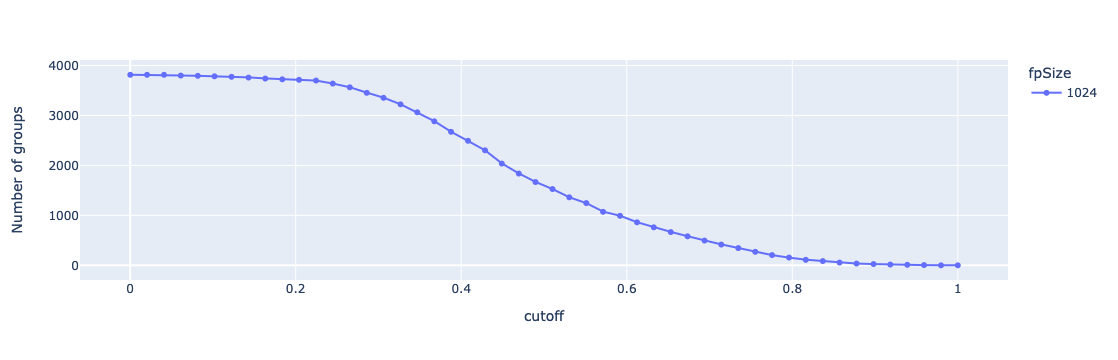

In [14]:
from collections import Counter
rows = []
df_sizes = []
for ids,kw_other in all_ids_kw:
    sizes = list(Counter(ids).values())
    row_stats = {"Number of groups":len(set(ids)),
                 "Group size mean":np.mean(sizes),
                 "Group size stdev":np.std(sizes),**kw_other}
    rows.append(row_stats)
    df_sizes.append(pandas.DataFrame({"Group size":sizes,**row_stats}))
df_groups = pandas.DataFrame(rows)
df_cat_sizes = pandas.concat(df_sizes)
px.line(df_groups,x="cutoff",color="fpSize",y="Number of groups",markers=True).show()

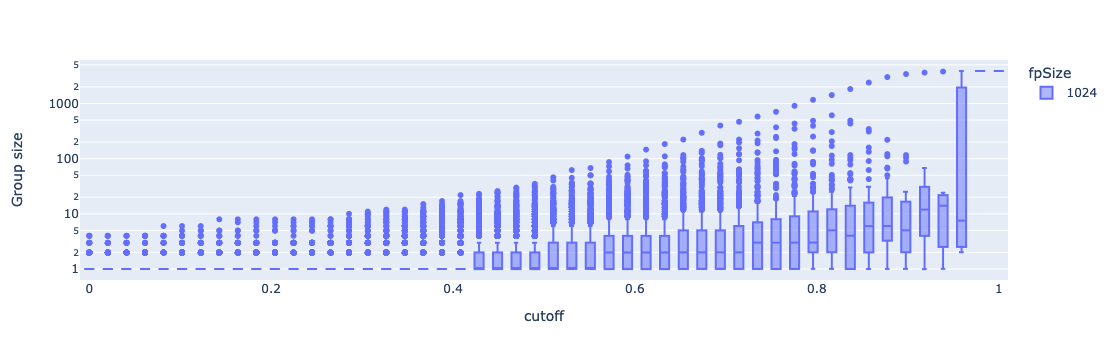

In [19]:
px.box(df_cat_sizes,x="cutoff",color="fpSize",y="Group size",points="outliers",log_y=True).show()

In [ ]:
df_fingerprints = []
generators = [
    ['ttgen', rdFingerprintGenerator.GetTopologicalTorsionGenerator],
    ['apgen', rdFingerprintGenerator.GetAtomPairGenerator],
    ["mgngen",rdFingerprintGenerator.GetMorganGenerator],
    ['rdkgen',rdFingerprintGenerator.GetRDKitFPGenerator],
]
for label,generator in tqdm(generators):
    for fingerprint_size in tqdm([128,512,1024,2048]):
        grid, _, _, _, _  = fit(mols,pka,radius = 2,fingerprint_size=fingerprint_size,params=None,
                               n_jobs=-2,generator=generator)
        df_errors = flatten_errors(grid)
        df_errors["bits"] = fingerprint_size
        df_errors["fp_type"] = label
        errors_grid = [df_errors,grid]
        df_fingerprints.append(errors_grid)

In [ ]:
df_cat = pandas.concat([d[0] for d in df_fingerprints])
px.line(df_cat,y="Score",error_y="Score error",line_dash="bits",facet_row="fp_type",
        x="n_estimators",color="Set",facet_col="max_depth").show(renderer=renderer)